In [1]:
import os
from math import log10
import numpy as np
import pandas as pd
import torch
import math
import torchvision.utils as utils
from torch.autograd import Variable
import pytorch_ssim
from PIL import Image
from torchvision.transforms import Compose, ToTensor, RandomCrop, ToPILImage, Resize

In [2]:
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [3]:
home_dir = '/Users/Sean/desktop/'

In [4]:
image_name = 'img_cow.jpg'
hr_image_dir = home_dir + 'test_result/' + 'hr_' + image_name
lr_image_dir = home_dir + 'test_result/' + 'lr_' + image_name
other_image_dir = home_dir + 'test_result/' + 'others_out_srf_4_lr_' + image_name
OOIS2012_AUG_image_dir = home_dir + 'test_result/' + 'OOIS2012_AUG_out_srf_4_lr_' + image_name
OOIS2012_image_dir = home_dir + 'test_result/' + 'OOIS2012_out_srf_4_lr_' + image_name
VOC2012_image_dir = home_dir + 'test_result/' +  'VOC2012_out_srf_4_lr_' + image_name

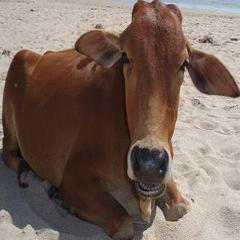

In [6]:
image = Image.open(hr_image_dir)
w, h = image.size
crop_size = calculate_valid_crop_size(min(w, h), 4)
def train_hr_transform(crop_size, upscale_factor): 
    return Compose([
        Resize((crop_size , crop_size ), interpolation=Image.BICUBIC)
    ])
hr_transform = train_hr_transform(crop_size, 4)
hr_image = hr_transform(image)
hr_image

In [7]:
hr_image.size

(240, 240)

In [38]:
hr_image.save(hr_image_dir)

In [6]:
def train_lr_transform(crop_size, upscale_factor): 
    return Compose([
        Resize((crop_size // upscale_factor, crop_size // upscale_factor), interpolation=Image.BICUBIC)
    ])

In [7]:
lr_transform = train_lr_transform(crop_size, 4)

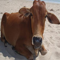

In [8]:
lr_image = lr_transform(hr_image)
lr_image

In [9]:
lr_image.size

(60, 60)

In [10]:
lr_image.save(lr_image_dir)

In [11]:
# test generator on HPC

print('wait a minute')


wait a minute


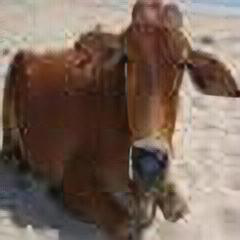

In [12]:
other_image = Image.open(other_image_dir)
other_image

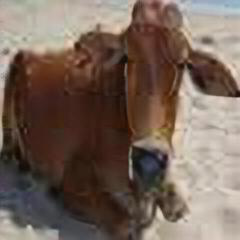

In [13]:
OOIS2012_AUG_image = Image.open(OOIS2012_AUG_image_dir)
OOIS2012_AUG_image

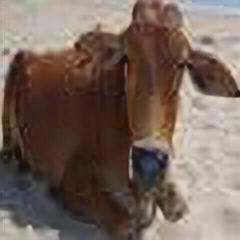

In [14]:
OOIS2012_image = Image.open(OOIS2012_image_dir)
OOIS2012_image

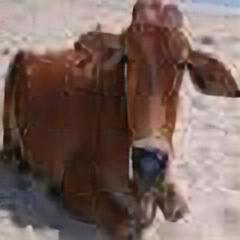

In [15]:
VOC2012_image = Image.open(VOC2012_image_dir)
VOC2012_image

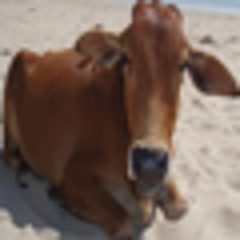

In [33]:
# bicubic upsampling
def bicubic_upsampling(image_size , upscale_factor): 
    return Compose([
        Resize(image_size * upscale_factor, interpolation=Image.BICUBIC)
    ])
upsampling = bicubic_upsampling(lr_image.size[1], 4)
bicubic_image = upsampling(lr_image)
bicubic_image

### Evaluation

In [16]:
def psnr(img1, img2):
    mse = ((img1 - img2) ** 2).data.mean()
    score = 10 * math.log10(1 / mse)
    return score
def ssim(img1, img2):
    score = pytorch_ssim.ssim(img1, img2).data[0]
    return score

In [17]:
def evaluation(test_image):
    
    tf_tensor=Compose([ToTensor()])
    
    hr_tensor = tf_tensor(hr_image).unsqueeze(0)
    lr_tensor = tf_tensor(test_image).unsqueeze(0)
    hr_variable = Variable(hr_tensor, volatile=True)
    lr_variable = Variable(lr_tensor, volatile=True)
    
    psnr_score = psnr(Variable(hr_tensor, volatile=True), Variable(lr_tensor, volatile=True))
    ssim_score = ssim(hr_variable,lr_variable)
    return psnr_score, ssim_score

In [18]:
test_image = other_image 
print ('PSNR: %.4f dB SSIM: %.4f' % (evaluation(test_image)[0], evaluation(test_image)[1]))

PSNR: 26.0830 dB SSIM: 0.6724


In [19]:
test_image = OOIS2012_AUG_image 
print ('PSNR: %.4f dB SSIM: %.4f' % (evaluation(test_image)[0], evaluation(test_image)[1]))

PSNR: 26.0198 dB SSIM: 0.6787


In [20]:
test_image = OOIS2012_image 
print ('PSNR: %.4f dB SSIM: %.4f' % (evaluation(test_image)[0], evaluation(test_image)[1]))

PSNR: 25.9209 dB SSIM: 0.6723


In [21]:
test_image = VOC2012_image 
print ('PSNR: %.4f dB SSIM: %.4f' % (evaluation(test_image)[0], evaluation(test_image)[1]))

PSNR: 25.8599 dB SSIM: 0.6674


In [34]:
test_image = bicubic_image 
print ('PSNR: %.4f dB SSIM: %.4f' % (evaluation(test_image)[0], evaluation(test_image)[1]))

PSNR: 27.5345 dB SSIM: 0.7619
